In [1]:
import os 
import pandas as pd 
import numpy as np 
import tarfile
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# paths 
path_tryptic_pep= '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/tryptic_peptide_fastas'

path_filtered_pep = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/v2_v2.5f0752a_conf2_annotFrame_cap0_runs_pya0.17.1/TCGA_Breast_1102'

commit_interest = 'commit_d4aee54_GTEXcore' # hardcoded cohort 

path_eth = os.path.join(path_tryptic_pep, 'G_tryptic_peptides')

file_name = 'peptide-extracted-filter.fasta'

In [3]:
samples = ['TCGA-BH-A18V-01A-11R-A12D-07','TCGA-C8-A12P-01A-11R-A115-07',
           'TCGA-A2-A0D2-01A-21R-A034-07','TCGA-A2-A0SX-01A-12R-A084-07',
           'TCGA-AO-A0JM-01A-21R-A056-07']

In [62]:
sample = samples[-1]

In [35]:
# Tryptic digestion products from Andy Lin 
data_tryptic = []
counter = 0 
with open(os.path.join(path_eth, 'G_' + sample, file_name ), 'r') as f: 
    for line in f.readlines():
        if 'pepID' in line:
            counter +=1
            data_tryptic.append ([line.split('\n')[0]])
        else:
            data_tryptic[-1].extend([counter, line.split('\n')[0]])


data_tryptic = pd.DataFrame(data_tryptic)
data_tryptic.columns = ['id', 'counter', 'tryptic_seq']

In [36]:
assert(data_tryptic['id'].unique().shape[0] == data_tryptic.shape[0])

In [37]:
data_tryptic.shape

(24764, 3)

In [38]:
data_tryptic['id'].unique().shape[0]

24764

In [39]:
data_tryptic['tryptic_seq'].unique().shape

(2757,)

In [40]:
# Filtered peptides to query (longlist for sample)
data_meta = []
with open(os.path.join(path_filtered_pep, f'filter_{sample}.all', commit_interest, f'G_{sample}_query_peptides.fa'), 'r') as f :
    for line in f.readlines():
        if 'pepID' in line:
            data_meta.append(line.split('\n')[0].split(';'))
        else:
            data_meta[-1].extend([line.split('\n')[0]])

data_meta = pd.DataFrame(data_meta)
data_meta.columns = ['id', 'jx_pos', 'between_codons', 'include5', 'include3', 'gene', 'coord', 'seq']

In [41]:
data_meta.head(3)

,id,jx_pos,between_codons,include5,include3,gene,coord,seq
0,>pepID-1,jx_pos-12,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000119333.11,jx_coord-128640690_128636438,WLRGELDRAAADGWTMGTGARLSPSCVPGTWTGETCVPSSRRPWWR...
1,>pepID-2,jx_pos-27,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000086758.16,jx_coord-53550665_53549505,ATVGSSILALLCREVAPSRWGVAAAITGLLAVM
2,>pepID-3,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...


In [42]:
# merge tryptic, peptide metadata
df = data_meta.merge(data_tryptic, on = 'id', how = 'outer')

df['len_pep'] = [len(x) for x in df['seq']]

df['has_tryptic'] = 1
df.loc[df['tryptic_seq'].isna(), 'has_tryptic'] = 0 

In [43]:
df

,id,jx_pos,between_codons,include5,include3,gene,coord,seq,counter,tryptic_seq,len_pep,has_tryptic
0,>pepID-1,jx_pos-12,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000119333.11,jx_coord-128640690_128636438,WLRGELDRAAADGWTMGTGARLSPSCVPGTWTGETCVPSSRRPWWR...,1.0,AAADGWTMGTGAR,116,1
1,>pepID-2,jx_pos-27,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000086758.16,jx_coord-53550665_53549505,ATVGSSILALLCREVAPSRWGVAAAITGLLAVM,2.0,WGVAAAITGLLAVM,33,1
2,>pepID-3,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...,NaN,NaN,123,0
3,>pepID-4,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...,NaN,NaN,123,0
4,>pepID-5,jx_pos-90,between_codons-0,includes_5'-1,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174724853_174725017,MASPSKGNDLFSPDEEGPAVVAGPGPGPGGAEGAAEERRVKVSSLP...,3.0,TYEPYHLHPEETQDQSEAAHALYHIPAPR,188,1
...,...,...,...,...,...,...,...,...,...,...,...,...
40137,>pepID-40138,jx_pos-24,between_codons-0,includes_5'-0,includes_3'-1,gene-ENSG00000134419.15,jx_coord-18783640_18783102,NLYPPNYASGALVESILTSWLLYYSFIVLTIFTNKMPHGLWCFHLV...,NaN,NaN,68,0
40138,>pepID-40139,jx_pos-24,between_codons-0,includes_5'-0,includes_3'-1,gene-ENSG00000134419.15,jx_coord-18783640_18783102,NLYPPNYASGALVESILTSWLLYYSFIVQIKCLMDSGASTWSF,NaN,NaN,43,0
40139,>pepID-40140,jx_pos-24,between_codons-0,includes_5'-0,includes_3'-1,gene-ENSG00000134419.15,jx_coord-18783640_18783102,NLYPPNYASGALVESILTSWLLYYSFIVQIKCLMDSGASTWSF,NaN,NaN,43,0
40140,>pepID-40141,jx_pos-24,between_codons-0,includes_5'-0,includes_3'-1,gene-ENSG00000134419.15,jx_coord-18783640_18783102,NLYPPNYASGALVESILTSWLLYYSFIVQIKCLMDSGASTWSF,NaN,NaN,43,0


In [82]:
df.shape

(40142, 12)

In [84]:
df['seq'].unique().shape

(4955,)

In [85]:
df['coord'].unique().shape

(4012,)

In [93]:
df.loc[ df['has_tryptic'] == 1 ].shape

(24764, 12)

In [95]:
df.loc[df['has_tryptic'] == 1 , 'tryptic_seq'].unique().shape

(2757,)

In [44]:
jct_test = 'jx_coord-174725038_174729158'

In [45]:
grp_len = df[['coord', 'len_pep']].groupby(['coord']).min().reset_index()

In [46]:
grp_len.head()

,coord,len_pep
0,jx_coord-100030375_100033304,323
1,jx_coord-1000469_997804,201
2,jx_coord-100097613_100097384,26
3,jx_coord-100097658_100102303,39
4,jx_coord-100097693_100097628,43


In [47]:
grp_len.loc[grp_len['coord'] == jct_test]

,coord,len_pep
1167,jx_coord-174725038_174729158,123


In [48]:
grp_len = df[['coord', 'len_pep']].groupby(['coord']).min().reset_index()

In [49]:
grp_trypt = df[['coord', 'tryptic_seq']].groupby(['coord', 'tryptic_seq']).count().reset_index()

grp_trypt = grp_trypt.groupby(['coord']).count().reset_index()

In [50]:
# grp_peptides.loc[grp_trypt['coord'] == jct_test]

# df.loc[df['coord'] == jct_test ]['tryptic_seq'].unique()

In [75]:
# Counting the number of peptides right 
grp_peptides = df[['coord', 'seq']].groupby(['coord', 'seq']).count().reset_index()
grp_peptides = grp_peptides.groupby(['coord']).count().reset_index()

In [78]:
df_plot = grp_trypt.merge(grp_peptides, on = 'coord', how = 'outer')

df_plot['tryptic_seq'] = df_plot['tryptic_seq'].fillna(0)
df_plot = df_plot.merge(grp_len, on = 'coord', how = 'outer')


In [104]:
df.loc[df['coord'] == 'jx_coord-21511196_21511149', ['jx_pos', 'coord', 'seq']].drop_duplicates()

,jx_pos,coord,seq
368,jx_pos-37,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSTESRGSIVSNLP
369,jx_pos-20,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSTESRGSIVSNLP
370,jx_pos-48,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSTESRGSIVSNLP
371,jx_pos-47,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSTESRGSIVSNLP
373,jx_pos-47,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPE...
374,jx_pos-37,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPE...
375,jx_pos-48,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPE...
377,jx_pos-20,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPE...
378,jx_pos-48,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSLLPDGRLSPTLVRLAHSSSDCEDVAFV...
379,jx_pos-47,jx_coord-21511196_21511149,MSDTWSSIQAEAGLGALGSLLPDGRLSPTLVRLAHSSSDCEDVAFV...


In [100]:
df.loc[df['coord'] == 'jx_coord-21511196_21511149', ['seq', 'tryptic_seq']]\
.groupby(['seq', 'tryptic_seq']).count()

Empty DataFrame
Columns: []
Index: [(MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPEWLAPQVYPTMPAYFLIFISL, AQVILLPQPPPEWLAPQVYPTMPAYFLIFISL), (MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLRAQVILLPQPPPEWLAPQVYPTMPAYFLIFISL, MSDTWSSIQAEAGLGALGLEFSGVNTAYCSLDLR), (MSDTWSSIQAEAGLGALGSLLPDGRLSPTLVRLAHSSSDCEDVAFVRLLSPLSREAARTPFCCCFGALFPQL, LAHSSSDCEDVAFVR), (MSDTWSSIQAEAGLGALGSLLPDGRLSPTLVRLAHSSSDCEDVAFVRLLSPLSREAARTPFCCCFGALFPQL, LLSPLSR), (MSDTWSSIQAEAGLGALGSLLPDGRLSPTLVRLAHSSSDCEDVAFVRLLSPLSREAARTPFCCCFGALFPQL, MSDTWSSIQAEAGLGALGSLLPDGR), (MSDTWSSIQAEAGLGALGSTESRGSIVSNLP, GSIVSNLP), (MSDTWSSIQAEAGLGALGSTESRGSIVSNLP, MSDTWSSIQAEAGLGALGSTESR)]

In [96]:
df_plot.loc[df_plot['tryptic_seq'] == 7.0]

,coord,tryptic_seq,seq,len_pep
928,jx_coord-21511196_21511149,7.0,4,26


In [79]:
df_plot.head()

,coord,tryptic_seq,seq,len_pep
0,jx_coord-100030375_100033304,1.0,1,323
1,jx_coord-1000469_997804,1.0,1,201
2,jx_coord-100097693_100097628,1.0,1,43
3,jx_coord-100098140_100097948,1.0,1,46
4,jx_coord-100098187_100097948,1.0,1,53


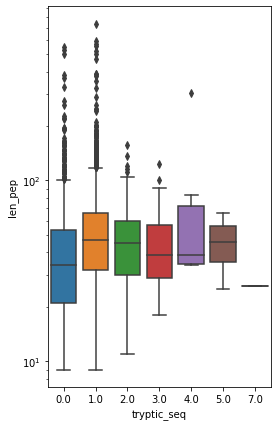

In [73]:
plt.figure(figsize = (4, 7 ))
sns.boxplot(data = df_plot, y = 'len_pep', x = 'tryptic_seq') # also version in log 
plt.yscale('log')

In [71]:
print([10**1, 10**1.1, 10**1.2, 10** 1.3, 10** 1.4, 10**1.5, 10**1.6, 10**1.7, 10**1.8, 10**1.9])

[10, 12.589254117941675, 15.848931924611133, 19.952623149688797, 25.118864315095795, 31.622776601683793, 39.810717055349734, 50.11872336272722, 63.09573444801933, 79.43282347242814]


In [70]:
10**1.38

23.9883291901949

In [69]:
10**1.23

16.982436524617444

<AxesSubplot:xlabel='tryptic_seq', ylabel='seq'>

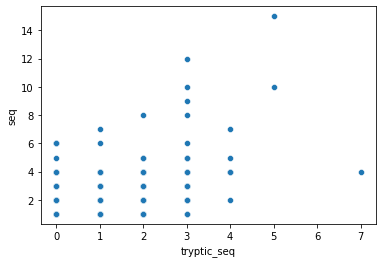

In [80]:
sns.scatterplot(data = df_plot, x = 'tryptic_seq', y = 'seq')

<AxesSubplot:xlabel='tryptic_seq', ylabel='Count'>

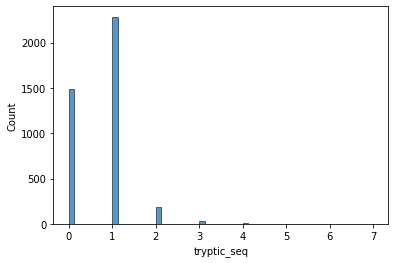

In [56]:
sns.histplot(data = df_plot, x = 'tryptic_seq')

<AxesSubplot:xlabel='seq', ylabel='Count'>

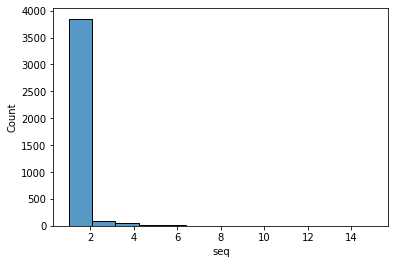

In [81]:
sns.histplot(data = df_plot, x = 'seq')

(array([950., 303., 443., 179., 447., 407., 210.,  83., 177.,   9.,  70.,
         45., 120.,  94.,   3.,  46.,  15.,  10.,  73.,  11.,   6.,  29.,
         23.,  21.,   3.,  32.,   4.,  15.,  24.,   2.,   0.,  20.,   2.,
         17.,   0.,  13.,   1.,   0.,  17.,   3.,   4.,   0.,   0.,   8.,
          9.,   1.,   0.,   0.,   6.,   0.,   0.,   3.,   1.,   4.,   1.,
          0.,   0.,   0.,   4.,   0.,   1.,   0.,   2.,   0.,   4.,   1.,
          0.,   3.,   3.,   1.,   0.,   3.,   4.,   0.,   0.,   0.,   1.,
          1.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   4.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

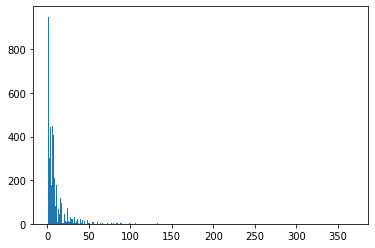

In [57]:
plt.hist(df_plot ['id'], bins = 300)

<AxesSubplot:>

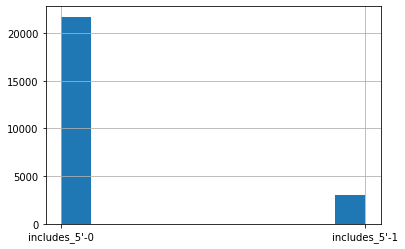

In [58]:
df.loc[df['has_tryptic'] == 1, 'include5'].hist()

<AxesSubplot:xlabel='include3', ylabel='Count'>

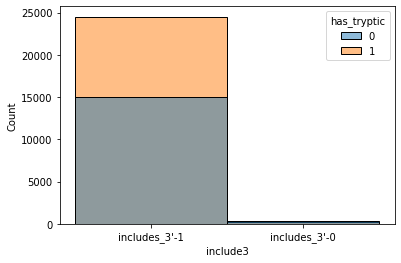

In [59]:
sns.histplot(data = df, x = 'include3', hue = 'has_tryptic')

<AxesSubplot:xlabel='include5', ylabel='Count'>

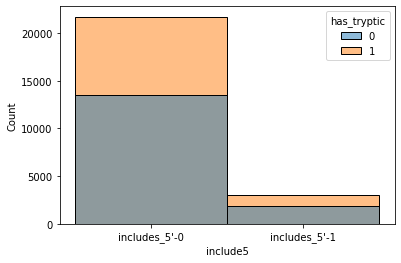

In [60]:
sns.histplot(data = df, x = 'include5', hue = 'has_tryptic')

(array([42052.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   534.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

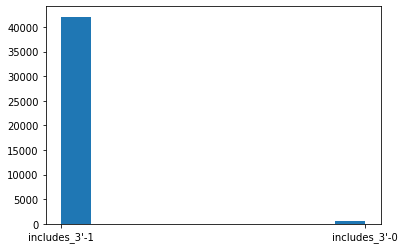

In [31]:
plt.hist(df['include3'])

# Checks from Cancer Cell Paper 

In [32]:
asn_exp = pd.read_csv('/cluster/work/grlab/projects/TCGA/PanCanAtlas/peptides_neoantigen/analysis_pancan/ccell_rerun_2018/output/expression_distribution/asns/TCGA-AO-A0JM.asns_kmers_annotated.gtex.tsv', sep = '\t')

In [33]:
asn_exp.loc[#(foo['PEPTIDE_TYPE'] == 'reference') &\
         (foo['JUNC_COUNT'] > 0 ) &\
       (foo['IN_CPTAC'] == 1), :]

NameError: name 'foo' is not defined

In [ ]:
kmer = 'ENSG00000133392.12'
[idx for idx, seq in enumerate(df['gene']) if kmer in seq]

In [ ]:
df.iloc[[14250, 24616, 24617, 24822, 24823, 32986, 32987, 36317, 36318]]

In [ ]:
asn_final = pd.read_csv('/cluster/work/grlab/projects/TCGA/PanCanAtlas/peptides_neoantigen/analysis_pancan/ccell_rerun_2018/output/cptac_mhc/filtered/filtered_for_new_junctions/sites/expression_filtered/TCGA-A2-A0YM.gtex.unique_novel_junction_binders.2.0.annotated.sites.expressed.txt', '\t')

In [ ]:
asn_final.head()

In [ ]:
# Prensent one sample in the power point = the A0 -- plot from yesterday also in A 0 